### House Prices - Advanced Regression Techniques 

回家作業: [House prices: Lasso, XGBoost, and a detailed EDA](https://www.kaggle.com/code/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda) (R語言)

Python語言 3篇:<br>
排行榜前4% [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard)<br>
進階內容 [Comprehensive data exploration with Python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)<br>
適合初學 [A study on Regression applied to the Ames dataset](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset)<br>

---
### 先去看一看這個競賽要我們做甚麼 ?

[House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

![kaggle_house_prices](./ScreenShot/kaggle_house_prices_hight_light.png)

---
### 再去看一看原始的資料內容 
資料集: [Dataset Description](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv)

In [ ]:
!pip install scikit-learn

---
### 接著開始Trace程式碼

In [3]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [ ]:
!pip install scikit-learn

---
### 讀取 訓練資料集

這邊要先到網站上下載 [train.csv](https://storage.googleapis.com/kagglesdsdata/competitions/5407/868283/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1715331218&Signature=GNm74UnXsm%2F7mfN3%2BA3SkSlXd4Mvik3461SGKHjkgd7pkT%2FtxjiVWY%2BHkZmyZJwbG%2BCCbdHd6n1rML5l0Ky%2BQ%2BraH%2FDWfoPvimJPvTIKpHntoRsjEV7lcW51awvCYsVITMCCOXJM2nHbJbOdDtiTYxDlDPQliDcxG%2F7QlXoqVejRi%2FGJc%2FqaXR55YQCbQob4Mjy6%2FIN431djZS6ZtxIFFAOed7LDlH7J3BFGEeBNLkTHLz56m8YUnpfIvjyQilPY2O%2FInEcfHECOGBoVkzG%2FCjOiGV8kXS0ob7jnVSO8anAtzxXeGUSzXSoFb2JC9R%2FWFUkueWUM8mIl8tlyaZ8LQg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv)

在Data標籤頁的最下面 [Data](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

In [4]:
# Get data
train = pd.read_csv("./train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


---
### 檢查重複項

透過ID 檢查有沒有 重複的項目

確定沒有 ID重複 的資料，就把ID這個欄位全部 Drop 掉

因為ID這個欄位 只代表 有幾筆資料，跟我們想要預測的 "房價" 一點關聯性都沒有

也就是說 不可能這樣推測:<br>
第273筆的房屋 -> 大約是 4800萬<br>
第462筆的房屋 -> 大約是 2760萬

In [5]:
# 透過ID 檢查是否有 重複的項目
# Check for duplicates

print(type(train.Id))
idsUnique = len(set(train.Id)) # 把這筆資料放進set，Python當中 Set資料型態的特性 是重複的資料 只會出現一次
idsTotal = train.shape[0] # Train 總數量
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# ID 只是表示說我有幾筆資料，並無法反映房屋的任何特徵，對於訓練來說是沒用的資料，所以Drop掉
# Drop Id column
train.drop("Id", axis = 1, inplace = True)

<class 'pandas.core.series.Series'>
There are 0 duplicate IDs for 1460 total entries


---
### 剔除離群值 (Outlier)

但一開始看不懂怎麼辦 ? 把它畫 or 印出來，看它在幹嘛

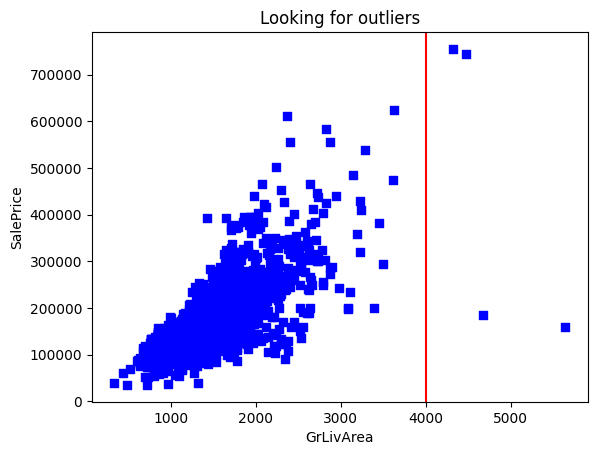

Before: 1460
After: 1456


In [6]:
# 使用 plot 繪製圖表，來查看 房屋面積的平方英尺【GrLivArea】 離群值
# 橫軸房屋面積，縱軸價格

# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")


plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

# 在 x=4000 畫一條紅色線 (這條是我自己畫的)
plt.axvline(x = 4000, color = 'r', label = 'axvline - full height') 

plt.show()

print('Before:', len(train))
train = train[train.GrLivArea < 4000] # 地面上面積小於 4000 平方英尺拿掉
print('After:', len(train))

---
### 這邊是遵從 原論文作者建議，拿掉地面上面積大於4000平方英尺的資料

在第4頁: [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](https://jse.amstat.org/v19n3/decock.pdf)

![thesis_Dean_de_cock](.\ScreenShot\thesis_Dean_de_cock.png)

### 但在老師給的回家作業中 - House prices: Lasso, XGBoost, and a detailed EDA

只剔除 2個 離群值


![kaggle_outliers](./ScreenShot/kaggle_2_outliers.png)



---
### 又看不懂了

In [ ]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

### 一樣再把它畫出來

這邊畫出

房價從: 0~10萬、10萬~20萬、20萬~30萬 (以此類推) 每個區間的房子 各有幾筆


可以看到 這邊的資料經過 np.log1p 做處理

上網稍微查了一下，是一個叫做 平滑處理 的資料處理方式

至於甚麼叫做平滑處理，為何要做平滑處理? 就再請其他高手分享了~

Text(0, 0.5, 'Number of Items')

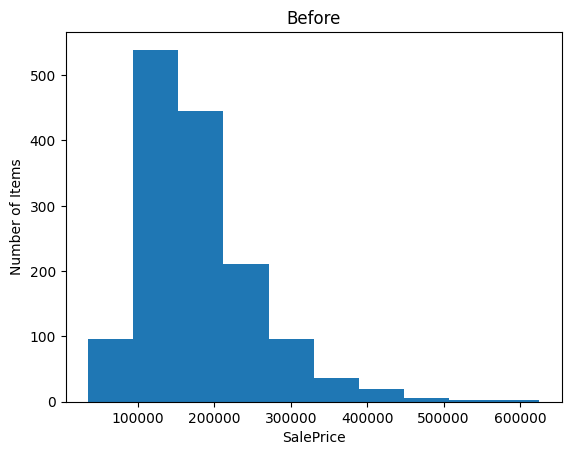

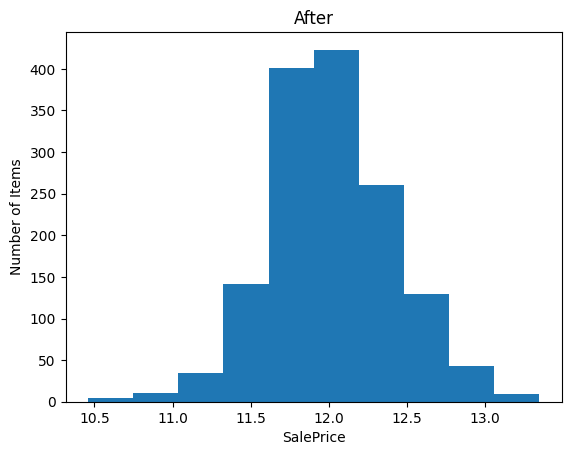

In [7]:
################### 處理前 ###################
plt.figure(1)
arr_counts_1, arr_bins_1, obj_1 = plt.hist(train.SalePrice)
plt.title('Before')
plt.xlabel("SalePrice")
plt.ylabel("Number of Items")

################### 透過 log1p 做處理 ###################
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

################### 處理後 ###################
plt.figure(2)
plt.title('After')
arr_counts_2, arr_bins_2, obj_2 = plt.hist(y)
plt.xlabel("SalePrice")
plt.ylabel("Number of Items")

### 【log1p】 平滑處理
這裡使用 np.log1p來對 SalePrice 資料進行 預處理

目的是將 資料數字縮小，並且改以高斯分布

猜測 能讓訓練出來的模型 更好的預測房價

但為何這樣做，就能導致模型更精準 ?

參考資料: 
[MDN Web docs](https://developer.mozilla.org/zh-CN/docs/Web/JavaScript/Reference/Global_Objects/Math/log1p)、
[AI學習平台](https://www.cupoy.com/qa/club/ai_tw/0000016D6BA22D97000000016375706F795F72656C656173654B5741535354434C5542/0000017700F271D9000000106375706F795F72656C656173655155455354)

<img src=".\ScreenShot\mdn_web_doc.png">

<img src=".\ScreenShot\mdn_web_doc_log1p.jpg">


### 處理 缺失值 (Missing Value)

對空值NA值做處理，這邊就是暴力硬幹

pandas.DataFrame.fillna: [API - Doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html)

參考資料: [Medium - Pandas.fillna](https://medium.com/@zector1030/pandas-fillna-%E7%AF%84%E4%BE%8B-5d33819fb7b8)

In [173]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

有些數字，只是代表 分類的一個代稱，而不是一個具有真正意義的數字 (對於訓練來說沒意義)

所以把這些沒有真實意義的數字，改成一個簡單的代稱

In [174]:
# Some numerical features are actually really categories
train = train.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)


假設某個欄位有等級高低的，就改用數字來表示它，而非 英文縮寫

![kaggle_BsmtCond](./ScreenShot/kaggle_BsmtCond.png)
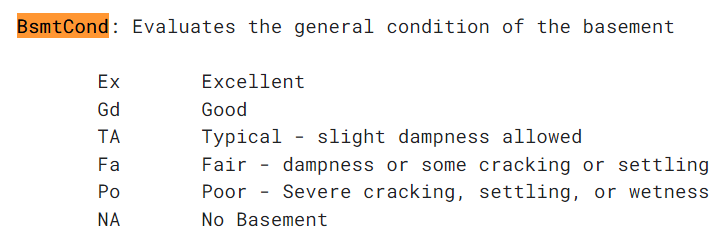

In [175]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace(
    {
        "Alley": {"Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)


---
### 新增 原本資料集 簡化後的欄位(特徵)

In [177]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace(
    {
        1: 1,
        2: 1,
        3: 1,  # bad
        4: 2,
        5: 2,
        6: 2,  # average
        7: 3,
        8: 3,
        9: 3,
        10: 3,  # good
    }
)
train["SimplOverallCond"] = train.OverallCond.replace(
    {
        1: 1,
        2: 1,
        3: 1,  # bad
        4: 2,
        5: 2,
        6: 2,  # average
        7: 3,
        8: 3,
        9: 3,
        10: 3,  # good
    }
)
train["SimplPoolQC"] = train.PoolQC.replace(
    {
        1: 1,
        2: 1,  # average
        3: 2,
        4: 2,  # good
    }
)
train["SimplGarageCond"] = train.GarageCond.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplGarageQual"] = train.GarageQual.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplFireplaceQu"] = train.FireplaceQu.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplFireplaceQu"] = train.FireplaceQu.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplFunctional"] = train.Functional.replace(
    {
        1: 1,
        2: 1,  # bad
        3: 2,
        4: 2,  # major
        5: 3,
        6: 3,
        7: 3,  # minor
        8: 4,  # typical
    }
)
train["SimplKitchenQual"] = train.KitchenQual.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplHeatingQC"] = train.HeatingQC.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace(
    {
        1: 1,  # unfinished
        2: 1,
        3: 1,  # rec room
        4: 2,
        5: 2,
        6: 2,  # living quarters
    }
)
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace(
    {
        1: 1,  # unfinished
        2: 1,
        3: 1,  # rec room
        4: 2,
        5: 2,
        6: 2,  # living quarters
    }
)
train["SimplBsmtCond"] = train.BsmtCond.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplBsmtQual"] = train.BsmtQual.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplExterCond"] = train.ExterCond.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)
train["SimplExterQual"] = train.ExterQual.replace(
    {
        1: 1,  # bad
        2: 1,
        3: 1,  # average
        4: 2,
        5: 2,  # good
    }
)


---
### 繼續新增 簡化後的資料集 欄位(特徵)

例如: 將某兩個相關的特徵相乘，產生出一個新的特徵

OverallGrade = OverallQual * OverallCond

房屋等第 = 建材品質分數 * 房屋現況分數

![kaggle_OverallQua](./ScreenShot/kaggle_OverallQual.png)

In [179]:
# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]


 [ Length of train: 108 ]


In [180]:
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]


 [ Length of train: 112 ]


In [181]:
# Has masonry veneer or not
pd.set_option('future.no_silent_downcasting', True)

train["HasMasVnr"] = train.MasVnrType.replace(
    {"BrkCmn": 1, "BrkFace": 1, "CBlock": 1, "Stone": 1, "None": 0}
)
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace(
    {"Abnorml": 0, "Alloca": 0, "AdjLand": 0, "Family": 0, "Normal": 0, "Partial": 1}
)


 [ Length of train: 114 ]


### 找出與 預測的目標(SalesPrice) 高度相關的 特徵 (欄位)

白話: 計算 哪些房子的條件，更直接影響房價

然後就出問題了 (還以為遇到東巴)

In [134]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target


ValueError: could not convert string to float: 'SC60'

### Degug

Stack overflow: [複製貼上工程師](https://stackoverflow.com/questions/76533178/corr-results-in-valueerror-could-not-convert-string-to-float)

![stack_overflow_numeric_only_true](./ScreenShot/stack_overflow_numeric_only_true.png)

In [182]:
# Find most important features relative to target
print("Find most important features relative to target")

# corr = train.corr() 多加 numeric_only=True 
corr = train.corr(numeric_only=True)

corr.sort_values(["SalePrice"], ascending = False, inplace = True)

for index in corr.SalePrice.index:
    print(f'{str(index) :<20}{str(round(corr.SalePrice[index],3))}')

Find most important features relative to target
SalePrice           1.0
OverallQual         0.819
AllSF               0.817
AllFlrsSF           0.729
GrLivArea           0.719
SimplOverallQual    0.708
GarageCars          0.68
TotalBath           0.673
GarageArea          0.655
TotalBsmtSF         0.642
1stFlrSF            0.614
OverallGrade        0.604
FullBath            0.591
YearBuilt           0.589
YearRemodAdd        0.569
GarageYrBlt         0.544
TotRmsAbvGrd        0.533
SimplOverallGrade   0.527
Fireplaces          0.487
MasVnrArea          0.426
BsmtFinSF1          0.383
WoodDeckSF          0.331
OpenPorchSF         0.327
HalfBath            0.311
2ndFlrSF            0.307
LotArea             0.259
BsmtFullBath        0.239
BsmtUnfSF           0.223
BedroomAbvGr        0.204
AllPorchSF          0.199
LotFrontage         0.174
ScreenPorch         0.124
3SsnPorch           0.056
PoolArea            0.041
BsmtFinSF2          0.006
BsmtHalfBath        -0.015
MiscVal           

### 學習方法

**1. 番茄鐘 (25min 休5 min)**<br>
&emsp;通常我們認為 累了再去休息<br>
&emsp;但如果在大腦還沒累之前就先休息<br>
&emsp;是不是能讓大腦不會累 ? 來提升專注力<br>

**2. 一盞只有讀書才能開的檯燈**

**3. 睡覺**<br>
&emsp;促進大腦短期記憶轉長期記憶<br><br>
&emsp;短期記憶: 海馬迴<br>
&emsp;長期記憶: 大腦皮質

有效的學習方法(3min): https://www.youtube.com/watch?v=p5NDIY2ngg0

![yt_learning_method](./ScreenShot/yt_learning_method_marty.png)

---
### 如果這個世界也是一場遊戲，說不定能玩的很好

<span style="color:#569CD6;">遊戲缺點</span>: <span style="color:#CE9178;">天賦屬性未知

<span style="color:#569CD6;">陷阱</span>: <span style="color:#CE9178;">生活中遭遇的問題

<span style="color:#569CD6;">小怪</span>: <span style="color:#CE9178;">學習上的遇到的各種 "為甚麼" (小怪打不贏，就去找NPV學技能、買裝備)

<span style="color:#569CD6;">副本王</span>: <span style="color:#CE9178;">工作上遇到要解決的問題 (副本王打不贏，就回去推小怪、累積經驗值)

<span style="color:#569CD6;">世界王</span>: <span style="color:#CE9178;">人類起源、費米悖論、地外文明、等等世界的未解之謎...

<span style="color:#569CD6;">習得裝備/武器/技能</span>: <span style="color:#CE9178;">文學、地理學、表演、結構力學、心理學、藝術、歷史、數學、會計學、泥作、外語、生物學、民法刑法、法學導論、經濟學、電磁學、色彩學、流體力學 等等等列舉不完

<p style="text-align: center;"><span style="color:#CE9178;">那麼... 有沒有神裝呢 ?</span></p>

<span style="color:#569CD6;">遊戲攻略</span>: <span style="color:#CE9178;">Google、CheatGPT、Youtube 等等

![pronhub_calculus](./ScreenShot/pronhub_calculus.png)